###  Imports

In [1]:
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

### Get data from Reddit

In [2]:
depressedData = pd.read_csv('./../Data/depressed_posts.csv')
unpopularopinionData = pd.read_csv('./../Data/unpopularopinion_posts.csv')
lonelyData = pd.read_csv('./../Data/lonely_posts.csv')
machinelearningData = pd.read_csv('./../Data/machinelearning_posts.csv')

### Clean r/MachineLearning data

In [3]:
print(len(machinelearningData))

972


In [4]:
machinelearningData = machinelearningData[machinelearningData['Post'].notna()]
print(len(machinelearningData))

862


In [5]:
machinelearningData['Post'] = machinelearningData['Post'].astype(str)
print(len(machinelearningData))

862


In [6]:
allPosts = machinelearningData

posessivePronouns = "'s"
apostrophe="’"
someSigns ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = ' \d+(\.\d+)? '
punctuation = "[^\w\s]" 
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

allPosts['Post_Parsed'] = allPosts['Post'].str.lower()
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(posessivePronouns,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(apostrophe,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(someSigns,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(urls,' url ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(numbers,' nmbr ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(punctuation,' ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(whitespaces,' ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(leadTrailWhitespace,' ',regex=True)

In [7]:
allPosts.head()

,Author,Subreddit,Date,Title,Post,Post_Parsed
0,SisyphusGuy,MachineLearning,1.617899e+09,[D] Are there any reliable open-source out-of-...,I am looking through the [Face Anti-Spoofing s...,i am looking through the face anti spoofing se...
1,dadadidi,MachineLearning,1.616942e+09,[P] Guide: Finetune GPT2-XL (1.5 Billion Param...,I needed to finetune the GPT2 1.5 Billion para...,i needed to finetune the gpt2 nmbr billion par...
2,mroc_lak,MachineLearning,1.616579e+09,[D] How does one test for shortcut learning of...,"Hi all, \n\n \nI’ve come across reviews of Co...",hi all ive come across reviews of covid 19 dia...
3,jafioti,MachineLearning,1.617300e+09,[D] Adaptive Computation Time Uses?,I read the paper for Adaptive Computation Time...,i read the paper for adaptive computation time...
4,goktugkt,MachineLearning,1.618608e+09,[P] Minimal PyTorch Library for Natural Evolut...,https://github.com/goktug97/nes-torch\n\nMy ma...,url main goal with this project was to test m...


In [8]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [10]:
nrows = len(allPosts)
lemmatized_text_list = []

for post in allPosts.Post_Parsed:
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = post
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [11]:
allPosts['Post_Parsed'] = lemmatized_text_list

In [12]:
allPosts.loc[1]['Post_Parsed']

'i need to finetune the gpt2 nmbr billion parameter model for a project but the model didn t fit on my gpu so i figure out how to run it with deepspeed and gradient checkpointing which reduce the require gpu memory now it can fit on just one gpu here i explain the setup and command to get it run url be also able to fit the currently largest gpt neo model 2 7 b parameters on one nmbr gb vram gpu for finetuning but i think there might be some issue with huggingface implementation i hope this help some people who also want to finetune gpt2 but don t want to set up distribute train '

In [13]:
# stop words
with open('./../stopwords_no_punct.data', 'rb') as filehandle:
    # read the data as binary data stream
    stop_words_no_punct = pickle.load(filehandle)

In [14]:
from nltk.tokenize import word_tokenize
post_without_stop_words = []

for post in allPosts.Post_Parsed:
    text_tokens = word_tokenize(post)
    tokens_without_stop_words = [word for word in text_tokens if not word in stop_words_no_punct]
    post_without_stop_words.append((" ").join(tokens_without_stop_words))

allPosts['Post_Parsed'] = post_without_stop_words

In [15]:
allPosts.loc[1]['Post_Parsed']

'need finetune gpt2 nmbr billion parameter model project model fit gpu figure run deepspeed gradient checkpointing reduce require gpu memory fit one gpu explain setup command get run url also able fit currently largest gpt neo model 2 7 b parameters one nmbr gb vram gpu finetuning think might issue huggingface implementation hope help people also want finetune gpt2 want set distribute train'

In [16]:
machinelearningData = allPosts

machinelearningData.to_csv('machinelearning_posts_processed.csv', index=False)

### Generating Features

In [17]:
from nltk.tokenize import word_tokenize

def getWordFrequency(processedPostOutputFile):
    posts = pd.read_csv(processedPostOutputFile)

    allPostsConcat = ''
    for post in posts.Post_Parsed:
        if(type(post)==str):
            allPostsConcat+=post

    # create bag-of-words
    all_words = []

    words = word_tokenize(allPostsConcat)
    for word in words:
        all_words.append(word)

    all_words = nltk.FreqDist(all_words)
    
    return all_words

In [19]:
freqWordsMachinelearning = getWordFrequency('machinelearning_posts_processed.csv')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsMachinelearning)))
print('Most common words: {}'.format(freqWordsMachinelearning.most_common(100)))

word_features_lonely = list(freqWordsMachinelearning.keys())[:1500]

Number of words: 9670
Most common words: [('url', 1777), ('model', 936), ('use', 801), ('learn', 670), ('data', 571), ('nmbr', 546), ('train', 493), ('paper', 422), ('like', 381), ('work', 363), ('make', 362), ('would', 359), ('image', 306), ('one', 284), ('time', 275), ('find', 264), ('machine', 251), ('1', 247), ('ai', 247), ('ml', 238), ('project', 236), ('network', 236), ('get', 227), ('also', 226), ('know', 213), ('think', 211), ('research', 207), ('could', 202), ('base', 195), ('need', 195), ('new', 194), ('e', 189), ('want', 184), ('neural', 183), ('see', 183), ('dataset', 182), ('point', 171), ('problem', 169), ('try', 168), ('feature', 167), ('result', 166), ('english', 165), ('2', 164), ('many', 162), ('task', 157), ('look', 156), ('x200b', 156), ('interest', 155), ('0', 155), ('deep', 154), ('set', 149), ('code', 145), ('help', 144), ('post', 144), ('understand', 139), ('take', 138), ('build', 138), ('way', 137), ('well', 137), ('question', 136), ('x', 135), ('label', 135), 

[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


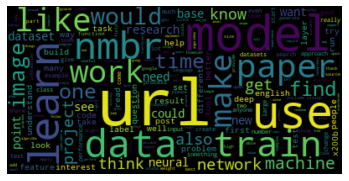

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
nltk.download('webtext')
data_analysis = freqWordsMachinelearning
 
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
 
wcloud = WordCloud().generate_from_frequencies(filter_words)
 
# Plotting the wordcloud
plt.imshow(wcloud, interpolation="bilinear")
 
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

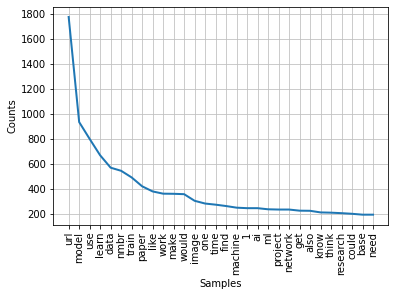

In [21]:
import matplotlib.pyplot as plt
freqWordsMachinelearning.plot(30,cumulative=False)
plt.show()